# Lab 3: Multiclass Classification with XGBoost

In [1]:
## Notebook Settings
# Add autotime of each block
!pip install ipython-autotime
%load_ext autotime

### Goals:
- Learn the basics of cyber network data with respect to consumer IoT devices
- Load network data into a data frame
- Explore network data and features
- Use XGBoost to build a classification model
- Evaluate the model
- Experiment on your own with feature selection, aggregation, and/or XGBoost parameters

This lab builds on the previous labs and will utilize some of those skills.

### Background

#### The Internet of Things and Data at a Massive Scale

Gartner estimates there are currently over 8.4 billion Internet of Things (IoT) devices. By 2020, that number is [estimated to surpass 20 billion](https://www.zdnet.com/article/iot-devices-will-outnumber-the-worlds-population-this-year-for-the-first-time/). These types of devices range from consumer devices (e.g., Amazon Echo, smart TVs, smart cameras, door bells) to commercial devices (e.g., building automation systems, keycard entry). All of these devices exhibit behavior on the Internet as they communicate back with their own clouds and user-specified integrations.

#### Types of Network Data

The most detailed type of data that is typically collected on a network is full Packet CAPture (PCAP) data. This information is detailed and contains everything about the communication, including: source address, destination address, protocols used, bytes transferred, and even the raw data (e.g., image, audio file, executable). PCAP data is fine-grained, meaning that there is a record for each frame being transmitted. A typical communication is composed of many individual packets/frames.

If we aggregate PCAP data so that there is one row of data per communication session, we call that flow level data. A simplified example of this relationship is shown in the figure below.

![PCAP_flow_relationship](pcap_vs_flow.png)

For this tutorial, we use data from the University of New South Wales. In a lab environment, they [collected nearly three weeks of IoT data from 21 IoT devices](http://149.171.189.1). They also kept a detailed [list of devices by MAC address](http://149.171.189.1/resources/List_Of_Devices.txt), so we have ground-truth with respect to each IoT device's behavior on the network.

**Our goal is to utilize the behavior exhibited in the network data to classify IoT devices.**

### Data Investigation

Let's first see some of the data. We'll load a PCAP file in using PyShark (a Python wrapper for Tshark).

In [2]:
import pyshark
cap = pyshark.FileCapture("/cwshare/unsw_iot/16-09-27.pcap")

time: 37.8 ms


In [3]:
print(cap[0])

Packet (Length: 156)
Layer ETH:
	Type: IPv4 (0x0800)
	Address: 14:cc:20:51:33:ea
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Destination: 14:cc:20:51:33:ea
	Source: 30:8c:fb:2f:e4:b2
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	Address: 30:8c:fb:2f:e4:b2
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
Layer IP:
	Source GeoIP: Unknown
	.... 0101 = Header Length: 20 bytes (5)
	Destination: 52.87.241.159
	0000 00.. = Differentiated Services Codepoint: Default (0)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	Fragment offset: 0
	Protocol: TCP (6)
	Destination GeoIP AS Number: AS14618 Amazon.com, Inc.
	Time to live: 64
	Identification: 0xd29e (53918)
	Header checksum: 0x7fc2 [validation disabled]
	0100 .... = Version: 4
	Total Length: 142
	Header checksum status: Unverified
	Destination GeoIP Longitude: -

In [4]:
print(cap[0].ip)

Layer IP:
	Source GeoIP: Unknown
	.... 0101 = Header Length: 20 bytes (5)
	Destination: 52.87.241.159
	0000 00.. = Differentiated Services Codepoint: Default (0)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	Fragment offset: 0
	Protocol: TCP (6)
	Destination GeoIP AS Number: AS14618 Amazon.com, Inc.
	Time to live: 64
	Identification: 0xd29e (53918)
	Header checksum: 0x7fc2 [validation disabled]
	0100 .... = Version: 4
	Total Length: 142
	Header checksum status: Unverified
	Destination GeoIP Longitude: -77.483803
	Destination GeoIP Latitude: 39.033501
	Destination GeoIP Country: United States
	..0. .... = More fragments: Not set
	.1.. .... = Don't fragment: Set
	Destination GeoIP City: Ashburn, VA
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Source: 192.168.1.106
	0... .... = Reserved bit: Not set
	Flags: 0x02 (Don't Fragment)
	Destination GeoIP: Ashburn, VA, United States, AS14618 Amazon.com, Inc., 39.033501, -77.483803

time: 1.31 ms


There's really a lot of features there! In addition to having multiple layers (which may differ between packets), there are a number of other issues with working directly with PCAP. Often the payload is encrypted (note the SSL layer in the above example), rendering it useless. The lack of aggregation also makes it difficult to differentiate between packets. What we really care about for this application is what a *session* looks like. In other words, how a Roku interacts with the network is likely quite different than how a Google Home interacts. 

To save time for the tutorial, all three weeks of PCAP data have already been transformed to flow data, and we can load that in to a typical Pandas dataframe. Due to how the data was created, we have a header row (with column names) as well as a footer row. We want to use the header but will skip the footer.

In [5]:
import pandas as pd
pdf = pd.read_csv("/cwshare/unsw_iot/bro/conn.log", sep='\t', skipfooter=1)
print("==> pdf shape: ",pdf.shape)

/opt/conda/envs/pygdf_dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


==> pdf shape:  (950384, 23)
time: 12.3 s


We can look at what this new aggregated data looks like, and get a better sense of the columns and their data types.

In [6]:
pdf.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,orig_l2_addr,resp_l2_addr
0,1.474553e+09,CIlOTU4kRBDOEJ2zf,192.168.1.241,61725,192.168.1.1,53,udp,dns,-,-,...,-,0,Dc,1,74,0,0,-,70:ee:50:18:34:43,14:cc:20:51:33:ea
1,1.474553e+09,CmV0US1aCCPzrVRz36,192.168.1.193,4425,192.168.1.223,49153,tcp,http,0.008820,196,...,-,0,ShADadfF,5,464,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
2,1.474553e+09,CEXvDL2UPDYnBDtd6h,192.168.1.193,4426,192.168.1.223,49153,tcp,http,0.008664,198,...,-,0,ShADadfF,5,466,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
3,1.474553e+09,CEXDAD42Irgl4M5go8,192.168.1.193,4977,192.168.1.249,49152,tcp,http,0.020995,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88
4,1.474553e+09,CW1YbA2fZzHrztJ0rl,192.168.1.193,4978,192.168.1.249,49152,tcp,http,0.018730,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88


time: 29.8 ms


In [7]:
pdf.dtypes

ts                float64
uid                object
id.orig_h          object
id.orig_p           int64
id.resp_h          object
id.resp_p           int64
proto              object
service            object
duration           object
orig_bytes         object
resp_bytes         object
conn_state         object
local_orig         object
local_resp         object
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents     object
orig_l2_addr       object
resp_l2_addr       object
dtype: object

time: 3.42 ms


In [8]:
# if time allows, investigate the data here

time: 476 µs


### Adding ground truth labels back to the data

We'll need some labels for our classification task, so we've already prepared a file with those labels.

In [9]:
labels_pdf = pd.read_csv("/cyshare/KDD2018/lab_mac_labels.csv", sep=',')
labels_pdf.head()

,Device,MAC,Connection,Category
0,Smart Things,d0:52:a8:00:67:5e,Wired,Hub
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,Speaker
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,Camera
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera


time: 10.5 ms


In order to use XGBoost, we need numeric category IDs. We'll use `.cat.codes` to create them and add them back to the labels data frame.

In [10]:
labels_pdf = labels_pdf.assign(CategoryID=(labels_pdf['Category']).astype('category').cat.codes)

time: 2.4 ms


In [11]:
labels_pdf.head()

,Device,MAC,Connection,Category,CategoryID
0,Smart Things,d0:52:a8:00:67:5e,Wired,Hub,6
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,Speaker,11
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera,1
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,Camera,1
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1


time: 9.19 ms


We now perform a series of merges to add the ground truth data (device name, connection, category, and categoryID) back to the dataset. Since each row of netflow has two participants, we'll have to do this twice - once for the originator (source) and once for the responder (destination).

In [12]:
merged_pdf = pd.merge(pdf,labels_pdf, how='left', left_on=['orig_l2_addr'], right_on=['MAC'])

time: 664 ms


In [13]:
merged_pdf = merged_pdf.rename(columns = {'Device':'orig_device',
                                          'MAC':'orig_MAC',
                                          'Connection':'orig_connection',
                                          'Category':'orig_category',
                                          'CategoryID':'orig_category_id'})

time: 907 ms


In [14]:
merged_pdf = pd.merge(merged_pdf,labels_pdf, how='left', left_on=['resp_l2_addr'], right_on=['MAC'])

time: 884 ms


In [15]:
merged_pdf = merged_pdf.rename(columns = {'Device':'resp_device',
                                          'MAC':'resp_MAC',
                                          'Connection':'resp_connection',
                                          'Category':'resp_category',
                                          'CategoryID':'resp_category_id'})

time: 1.01 s


Let's just look at our new dataset to make sure everything's okay.

In [16]:
merged_pdf.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,orig_device,orig_MAC,orig_connection,orig_category,orig_category_id,resp_device,resp_MAC,resp_connection,resp_category,resp_category_id
0,1.474553e+09,CIlOTU4kRBDOEJ2zf,192.168.1.241,61725,192.168.1.1,53,udp,dns,-,-,...,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera,1.0,TPLink Router Bridge LAN (Gateway,14:cc:20:51:33:ea,Wired,Router,10.0
1,1.474553e+09,CmV0US1aCCPzrVRz36,192.168.1.193,4425,192.168.1.223,49153,tcp,http,0.008820,196,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,Switch,12.0
2,1.474553e+09,CEXvDL2UPDYnBDtd6h,192.168.1.193,4426,192.168.1.223,49153,tcp,http,0.008664,198,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,Switch,12.0
3,1.474553e+09,CEXDAD42Irgl4M5go8,192.168.1.193,4977,192.168.1.249,49152,tcp,http,0.020995,186,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1.0
4,1.474553e+09,CW1YbA2fZzHrztJ0rl,192.168.1.193,4978,192.168.1.249,49152,tcp,http,0.018730,186,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1.0


time: 25.1 ms


In [17]:
merged_pdf.dtypes

ts                  float64
uid                  object
id.orig_h            object
id.orig_p             int64
id.resp_h            object
id.resp_p             int64
proto                object
service              object
duration             object
orig_bytes           object
resp_bytes           object
conn_state           object
local_orig           object
local_resp           object
missed_bytes          int64
history              object
orig_pkts             int64
orig_ip_bytes         int64
resp_pkts             int64
resp_ip_bytes         int64
tunnel_parents       object
orig_l2_addr         object
resp_l2_addr         object
orig_device          object
orig_MAC             object
orig_connection      object
orig_category        object
orig_category_id    float64
resp_device          object
resp_MAC             object
resp_connection      object
resp_category        object
resp_category_id    float64
dtype: object

time: 3.62 ms


### Exploding the Netflow Data into Originator and Responder Rows

We now have netflow that has one row per (sessionized) communication between an originator and responder. However, in order to classify an individual device, we need to explode data. Instead of one row that contains both originator and responder, we'll explode to one row for originator information (orig_bytes, orig_pkts, orig_ip_bytes) and one for responder information (resp_bytes, resp_pkts, resp_ip_bytes).

The easiest way to do this is to create two new dataframes, rename all of the columns, then `concat` them back together. Just for sanity, we'll also check the new shape of our exploded data frame.

In [18]:
orig_comms_pdf = merged_pdf[['ts','id.orig_h','id.orig_p','proto','service','duration','orig_bytes','orig_pkts','orig_ip_bytes',
                             'orig_device','orig_MAC','orig_category','orig_category_id']]
orig_comms_pdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts','ip_bytes','device','MAC','category','category_id']

time: 105 ms


In [19]:
resp_comms_pdf = merged_pdf[['ts','id.resp_h','id.resp_p','proto','service','duration','resp_bytes','resp_pkts','resp_ip_bytes',
                             'resp_device','resp_MAC','resp_category','resp_category_id']]
resp_comms_pdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts','ip_bytes','device','MAC','category','category_id']

time: 107 ms


In [20]:
exploded_pdf = pd.concat([orig_comms_pdf,resp_comms_pdf])
print("==> shape = ", exploded_pdf.shape)

==> shape =  (1900768, 13)
time: 387 ms


In [21]:
exploded_pdf.head()

,ts,ip,port,proto,service,duration,bytes,pkts,ip_bytes,device,MAC,category,category_id
0,1.474553e+09,192.168.1.241,61725,udp,dns,-,-,1,74,Netatmo Welcome,70:ee:50:18:34:43,Camera,1.0
1,1.474553e+09,192.168.1.193,4425,tcp,http,0.008820,196,5,464,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
2,1.474553e+09,192.168.1.193,4426,tcp,http,0.008664,198,5,466,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
3,1.474553e+09,192.168.1.193,4977,tcp,http,0.020995,186,5,454,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
4,1.474553e+09,192.168.1.193,4978,tcp,http,0.018730,186,5,454,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0


time: 18.5 ms


We're going to need the number of categories (classes) quite a bit, so we'll make a variable for it for easier access.

In [22]:
num_categories = int(len(exploded_pdf.groupby('category_id')['category_id'].nunique()))
print("==> number of IoT categories =", num_categories)

==> number of IoT categories = 13
time: 574 ms


### Binning the Data and Aggregating the Features

But wait, there's still more data wrangling to be done! While we've exploded the flows into rows for orig/resp, we may want to bin the data further by time. The rationale is that any single communication may not be an accurate representation of how a device typically reacts in its environment. Imagine the simple case of how a streaming camera typically operates (most of its data will be uploaded from the device to a destination) versus how it operates during a firmware update (most of the data will be pushed down to the device, after which a brief disruption in connectivity will occur).

There's a lof ot different time binning we could do. It also would be useful to investigate what the average duration of connection is relative to how many connections per time across various time granularities. With that said, we'll just choose a time bin of 1 hour to begin with. In order to bin, we'll use the following formula:

$$\text{hour_time_bin}=\left\lfloor{\frac{ts}{60*60}}\right\rfloor$$

In [23]:
import numpy as np

time: 807 µs


In [24]:
exploded_pdf['hour_time_bin'] = exploded_pdf['ts'].apply(lambda x: int(np.floor(x/(60*60))))

time: 2.34 s


We also have to make a choice about how we'll aggregate the binned data. One of the simplest ways is to sum the bytes and packets. There are really two choices for bytes, `bytes` and `ip_bytes`. With Bro, `bytes` is taken from the TCP sequence numbers and is potentially inaccurate, so we select `ip_bytes` instead for both originator and responder. We'll also use the sum of the number of packets.

In [25]:
one_hour_time_bin_pdf = exploded_pdf[['bytes','pkts','ip_bytes','MAC','category_id','hour_time_bin']].groupby(['MAC','category_id','hour_time_bin']).sum()
one_hour_time_bin_pdf = one_hour_time_bin_pdf.reset_index()

time: 309 ms


We finally have some data that's ready for classification. Let's take a look.

In [26]:
one_hour_time_bin_pdf.head()

,MAC,category_id,hour_time_bin,pkts,ip_bytes
0,00:16:6c:ab:6b:88,1.0,409598,67929,29754753
1,00:16:6c:ab:6b:88,1.0,409599,568,115454
2,00:16:6c:ab:6b:88,1.0,409600,679,129004
3,00:16:6c:ab:6b:88,1.0,409601,448,106468
4,00:16:6c:ab:6b:88,1.0,409602,549,111263


time: 7.21 ms


### Creating the Training and Testing Datasets

We'll take a tradition 70/30 train/test split, and we'll randomly sample into a train and test data frame.

In [27]:
pdf_msk = np.random.rand(len(one_hour_time_bin_pdf)) < 0.7

time: 1.31 ms


In [28]:
train_pdf = one_hour_time_bin_pdf[pdf_msk]
test_pdf = one_hour_time_bin_pdf[~pdf_msk]

print("==> train length =",len(train_pdf))
print("==> test length =",len(test_pdf))

==> train length = 5333
==> test length = 2386
time: 3.79 ms


Prepare the training input (`train_X`), training target (`train_Y`), test input (`test_X`) and test target (`test_Y`) datasets.

In [29]:
train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

time: 2.74 ms


### Configure XGBoost

**Finally** we're moving off the CPU and to the GPU with [XGBoost](https://xgboost.readthedocs.io/en/latest/). The package provides support for gradient boosted trees and can leverage distributed GPU compute environments.

In [30]:
import xgboost as xgb

time: 244 ms


Getting data into a format for XGBoost is really easy. Just make a `DMatrix` for both training and testin.

In [31]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

time: 1.97 ms


Like any good ML package, there's quite a few parameters to set. We're going to start with the softmax objective function. This will let us get a predicted category out of our model. We'll also set other parameters like the maximum depth and number of threads. You can read more about the parameters [here](https://xgboost.readthedocs.io/en/latest/parameter.html). Experiment with them!

In [32]:
param = {}
param['objective'] = 'multi:softmax'
param['eta'] = 0.1
param['max_depth'] = 13
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = num_categories
# param

time: 2.43 ms


XGBoost allows us to define a watchlist so what we can keep track of performance as the algorithm trains. We'll configure a simple watchlist that is watching `xg_train` and `xg_gest` error rates.

In [33]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

time: 847 µs


### Training our First XGBoost Model

Now it's time to train. Training is easy, keeping with the typical 80/20 rule for data science.

In [34]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.098256	test-merror:0.145013
[1]	train-merror:0.093381	test-merror:0.139145
[2]	train-merror:0.088506	test-merror:0.135792
[3]	train-merror:0.083255	test-merror:0.133277
[4]	train-merror:0.07913	test-merror:0.130763
[5]	train-merror:0.07763	test-merror:0.12741
[6]	train-merror:0.073692	test-merror:0.127829
[7]	train-merror:0.071067	test-merror:0.128248
[8]	train-merror:0.068629	test-merror:0.123638
[9]	train-merror:0.066379	test-merror:0.1228
[10]	train-merror:0.063754	test-merror:0.120704
[11]	train-merror:0.061879	test-merror:0.119866
[12]	train-merror:0.060379	test-merror:0.119447
[13]	train-merror:0.059629	test-merror:0.117351
[14]	train-merror:0.056066	test-merror:0.118189
[15]	train-merror:0.054753	test-merror:0.118609
[16]	train-merror:0.050816	test-merror:0.116513
[17]	train-merror:0.047628	test-merror:0.116513
[18]	train-merror:0.046128	test-merror:0.115675
[19]	train-merror:0.045753	test-merror:0.115675
time: 340 ms


Prediction is also easy (and fast).

In [35]:
pred = bst.predict(xg_test)

time: 1.32 ms


We might want to get a sense of how our model is by calculating the error rate.

In [36]:
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
error_rate

0.11567476948868399

time: 2.94 ms


That's not great, but it's not terrible considering we made quite a few seemingly abritrary decisions in both the feature selection and aggregation phases. Maybe we want to get some more insight into how our model is performing by analyzing the ROC curves for each class, micro average, and macro average. We'll revert back to traditional Python data science tools to do this analysis.

### Analyzing the Model's Performance

We'll start by importing some packages we'll need to perform this analysis. For simplicity in an already large notebook, we'll put them in a single cell.

In [37]:
# sklearn is used to binarize the labels as well as calculate ROC and AUC
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.preprocessing import label_binarize

# scipy is used for interpolating the ROC curves
from scipy import interp

# our old friend matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# choose whatever style you want
plt.style.use('fivethirtyeight')

# cycle is used just to make different colors for the different ROC curves
from itertools import cycle

time: 132 ms


A ROC curve analysis can be trickey for multiclass problems. One way to deal with it is to look at the ROC curve for each class. We'll take some steps to format our data so that it plays nicely with input requirements from sklearn (ah 80/20 rule, we meet again). We also will need to rerun our model with a different objective function.

### Rerunning the Model with the `softprob` Objective Function

We used the `softmax` objective function above, but what we really want out of model this time is probabilities that a netflow communication belongs to each of the classes. This is easy enough to do with XGBoost, as we just change the objective function to `softprob`. For simplicity, all of the configuration is in a single cell below rather than spread out. Note the only difference is the objective function change.

In [38]:
pdf_msk = np.random.rand(len(one_hour_time_bin_pdf)) < 0.7

train_pdf = one_hour_time_bin_pdf[pdf_msk]
test_pdf = one_hour_time_bin_pdf[~pdf_msk]

train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 8
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = num_categories

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

time: 7.77 ms


Train the model.

In [39]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.118977	test-merror:0.151959
[1]	train-merror:0.119162	test-merror:0.145071
[2]	train-merror:0.10897	test-merror:0.142919
[3]	train-merror:0.107116	test-merror:0.140336
[4]	train-merror:0.100815	test-merror:0.136031
[5]	train-merror:0.097294	test-merror:0.13474
[6]	train-merror:0.094329	test-merror:0.131726
[7]	train-merror:0.092476	test-merror:0.133448
[8]	train-merror:0.090067	test-merror:0.132587
[9]	train-merror:0.087658	test-merror:0.130004
[10]	train-merror:0.086546	test-merror:0.128713
[11]	train-merror:0.084507	test-merror:0.126991
[12]	train-merror:0.082468	test-merror:0.127421
[13]	train-merror:0.079689	test-merror:0.124408
[14]	train-merror:0.078391	test-merror:0.12613
[15]	train-merror:0.077465	test-merror:0.124839
[16]	train-merror:0.075426	test-merror:0.123978
[17]	train-merror:0.074129	test-merror:0.124408
[18]	train-merror:0.0745	test-merror:0.123978
[19]	train-merror:0.073388	test-merror:0.123547
time: 230 ms


Okay, so we have our new model. We now take some steps to make sure the data is in a format that makes sklearn happy. First we'll use the `predict` function to compute the probabilities. To extend `roc_curve` to multiclass, we'll also need to binarize the labels. Let's keep our sanity by also making sure the lengths match.

In [40]:
probs = bst.predict(xg_test).reshape(test_Y.shape[0],param['num_class'])
test_Y_binarize = label_binarize(test_Y, classes=np.arange(param['num_class']))

print("==> length of probs =",len(probs))
print("==> length of test_Y_binarize =", len(test_Y_binarize))

==> length of probs = 2323
==> length of test_Y_binarize = 2323
time: 4.02 ms


Some more housekeeping. We'll create Python dictionaries to hold FPR, TPR, and AUC values.

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()

time: 834 µs


For each of our classes, we'll computer FPR, TPR, and AUC. We're also compute the [micro and macro averages](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html).

In [42]:
print("==> number of classes =", num_categories)

==> number of classes = 13
time: 783 µs


In [43]:
# calculate FPR, TPR, and ROC AUC for every class
for i in range(num_categories):
    fpr[i], tpr[i], _ = roc_curve(test_Y_binarize[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# calculate the micro average FPR, TPR, and ROC AUC (we'll calculate the macro average below)
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y_binarize.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

time: 16.3 ms


### Plotting the ROC Curves

Phew! Lots of code below, but it's fairly straightofrward and [adapted from an example in the scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings). Before we plot though, we'll create a simple category lookup dictionary so we can label the classes with their actual names (not their category IDs).

In [44]:
category_lookup = labels_pdf[['Category','CategoryID']].drop_duplicates().set_index('CategoryID').T.to_dict()

time: 5.35 ms


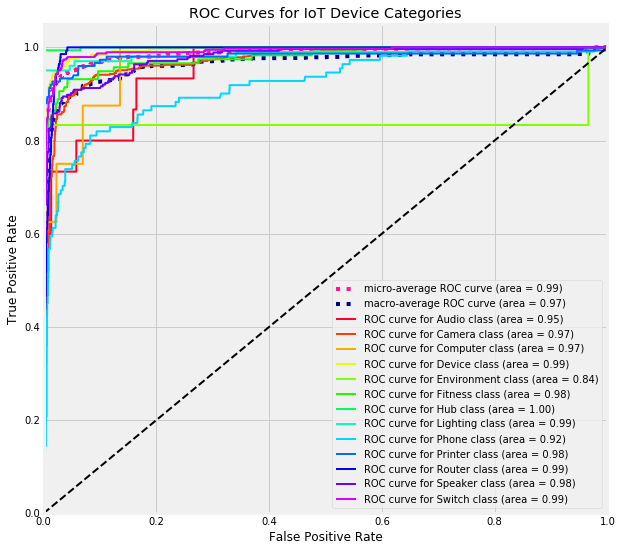

time: 353 ms


In [45]:
# aggregate all of the false positive rates across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_categories)]))

# interpolate all of the ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(param['num_class']):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average the TPR
mean_tpr /= num_categories

# compute the macro average FPR, TPR, and ROC AUC
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# plot all of the ROC curves on a single plot (for comparison)
plt.figure(figsize=(9,9))
plt.plot(fpr['micro'], tpr['micro'],
         label="micro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label="macro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

num_colors = param['num_class']
cm = plt.get_cmap('gist_rainbow')

colors = cycle([cm(1.*i/num_colors) for i in range(num_colors)])

lw = 2
for i, color in zip(range(param['num_class']), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label="ROC curve for "+category_lookup[i]['Category']+" class (area = {1:0.2f})"
             "".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for IoT Device Categories")
plt.legend(loc="lower right")
plt.show()

It's not a *terrible* plot, but it gets a little messy. We can also plot each class as its own subplot.

First we make a few variables so we can control the layout.

In [46]:
total_subplots = num_categories
plot_grid_cols = 3
plot_grid_rows = total_subplots // plot_grid_cols
plot_grid_rows += total_subplots % plot_grid_cols

position_index = range(1, total_subplots+1)

time: 1.25 ms


Now we make the grid of plots.

<Figure size 432x288 with 0 Axes>

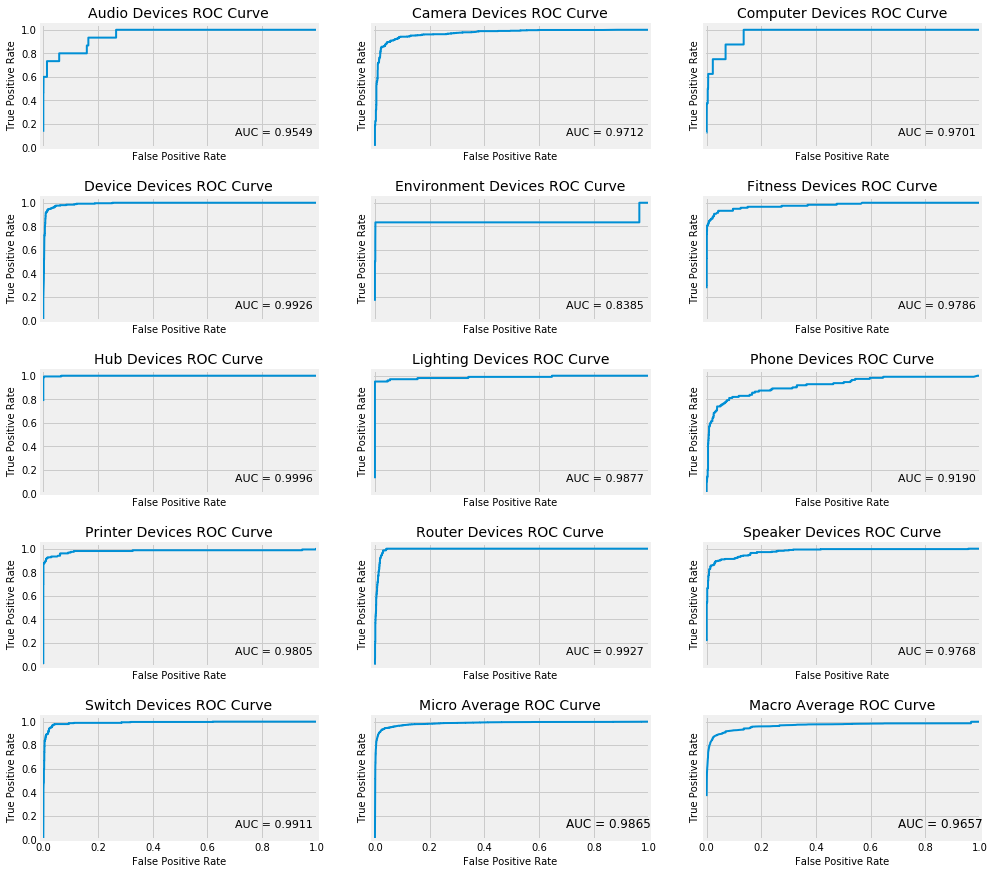

time: 1.2 s


In [47]:
plt.figure()
fig, axs = plt.subplots(plot_grid_rows, plot_grid_cols, sharex=True, sharey=True, figsize=(15,15))

lw = 2

plt_num = 0
for row in range(plot_grid_rows):
    for col in range(plot_grid_cols):
        if(plt_num <= 12):
            axs[row,col].plot(fpr[plt_num], tpr[plt_num], lw=lw)
            axs[row,col].set_title(category_lookup[plt_num]['Category']+' Devices ROC Curve', fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc[plt_num]), size=11)
        elif(plt_num == 13):
            axs[row,col].plot(fpr['micro'], tpr['micro'], lw=lw)
            axs[row,col].set_title("Micro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['micro']), size=12)
        elif(plt_num == 14):
            axs[row,col].plot(fpr['macro'], tpr['macro'], lw=lw)
            axs[row,col].set_title("Macro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['macro']), size=12)
        axs[row,col].set_xlabel('False Positive Rate', fontsize=10)
        axs[row,col].set_ylabel('True Positive Rate', fontsize=10)
        plt_num += 1
            
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### Conclusions

As we've shown, it's possible to get fairly decent multiclass classification results for IoT data using only basic features (bytes and packets) when aggregated. This isn't surprising, based on the fact that we used expert knowledge to assign category labels. In addition, the majority of the time, IoT devices are in a "steady state" (idle), and are not heavily influenced by human interaction. This lets us take larger samples (e.g., aggregate to longer time bins) while still maintaining decent classification performance.

We used Bro data, but it's also possible to use the raw PCAP data as input for classification. The preprocessing steps are more arduous than for flow data though. It'd be a great exercise...

### More to Explore: Possible Exercises

##### (1) It may be useful to investigate other time binnings. Can you build another model that uses data binned to a different granularity (e.g., 5 minutes)?

In [210]:
# your solution here

time: 730 µs


##### (2) We used the `sum` of bytes and packets for a device when aggregated to the hour. What about other ways to handle these quantitative features (e.g., average)? Would that improve the classification results?

In [ ]:
# your solution here

##### (3) We selected specific parameters for XGBoost. These could probably use a bit more thought. You can [read more about the parameters](https://xgboost.readthedocs.io/en/latest/parameter.html) and try adjusting them on our previous dataset.

In [214]:
# a reminder about our parameters
print(param)

{'eta': 0.1, 'nthread': 4, 'num_class': 13, 'max_depth': 8, 'objective': 'multi:softprob', 'silent': 1}
time: 1.17 ms


In [ ]:
# your solution here

##### (4) There are additional features in the netflow data that we didn't use. Some other quantitative fields (e.g., duration) and categorical fields (e.g., protocol, service, ports) may be useful for classification. Build another XGBoost model using some/all of these fields.

In [211]:
# your solution here

time: 515 µs


##### (5) We assigned categories to each device based on one expert's intuition. There are other ways to assign categories. Maybe there should be *fewer* categories even. Experiment with creating fewer categories, build a classification model, and compare your results with our previous findings.

In [212]:
# your solution here

time: 508 µs


##### (6) In addition to the Bro `conn` log, there are also additional logs that are generated as part of the process. One log is `dns.log`, and it includes the DNS requests and responses for all of the devices. It's [been](http://www2.eet.unsw.edu.au/~vijay/pubs/conf/17infocom.pdf) [shown](https://www.nanog.org/sites/default/files/Nadji.pdf) that the set of DNS along with the count of these requests can accurately classify IoT devices. Utilize the DNS log file to build a XGBoost classifier for IoT devices.

In [213]:
# this is a list of the Bro directory; Bro log types end in .log
!ls /cwshare/unsw_iot/bro/*.log

/cwshare/unsw_iot/bro/conn.log		 /cwshare/unsw_iot/bro/pe.log
/cwshare/unsw_iot/bro/dhcp.log		 /cwshare/unsw_iot/bro/ssh.log
/cwshare/unsw_iot/bro/dns.log		 /cwshare/unsw_iot/bro/ssl.log
/cwshare/unsw_iot/bro/dpd.log		 /cwshare/unsw_iot/bro/tunnel.log
/cwshare/unsw_iot/bro/files.log		 /cwshare/unsw_iot/bro/weird.log
/cwshare/unsw_iot/bro/http.log		 /cwshare/unsw_iot/bro/x509.log
/cwshare/unsw_iot/bro/packet_filter.log
time: 424 ms


In [ ]:
# your solution here

##### (7) There may be other interesting things in the netflow data. Investigate the data some more!

In [ ]:
# your solution here

### References

1. Nadji, Y., "Passive DNS-based Device Identification", *NANOG 67*, https://www.nanog.org/sites/default/files/Nadji.pdf.
1. Shams, R., "Micro- and Macro-average of Precision, Recall, and F-Score", http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html.
1. Sivanathan, A. et al., "Characterizing and Classifying IoT Traffic in Smart Cities and Campuses", *2017 IEEE Conference on Computer Communications Workshops*, May 2017, http://www2.eet.unsw.edu.au/~vijay/pubs/conf/17infocom.pdf.
1. University of New South Wales Internet of Things Network Traffic Data Collection, http://149.171.189.1

<hr>

### Possible Solutions

#### Possible Solution to (1)

In [ ]:
five_min_time_bin_pdf = exploded_pdf[['bytes','pkts','ip_bytes','MAC','category_id','5min_time_bin']].groupby(['MAC','category_id','5min_time_bin']).sum()
five_min_time_bin_pdf = five_min_time_bin_pdf.reset_index()

pdf_msk = np.random.rand(len(five_min_time_bin_pdf)) < 0.7

train_pdf = five_min_time_bin_pdf[pdf_msk]
test_pdf = five_min_time_bin_pdf[~pdf_msk]

train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 13
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = num_categories

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

In [ ]:
bst = xgb.train(param, xg_train, num_round, watchlist)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
# calculate FPR, TPR, and ROC AUC for every class
for i in range(num_categories):
    fpr[i], tpr[i], _ = roc_curve(test_Y_binarize[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# calculate the micro average FPR, TPR, and ROC AUC (we'll calculate the macro average below)
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y_binarize.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# aggregate all of the false positive rates across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_categories)]))

# interpolate all of the ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(param['num_class']):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average the TPR
mean_tpr /= num_categories

# compute the macro average FPR, TPR, and ROC AUC
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

In [ ]:
total_subplots = num_categories
plot_grid_cols = 3
plot_grid_rows = total_subplots // plot_grid_cols
plot_grid_rows += total_subplots % plot_grid_cols

position_index = range(1, total_subplots+1)

plt.figure()
fig, axs = plt.subplots(plot_grid_rows, plot_grid_cols, sharex=True, sharey=True, figsize=(15,15))

lw = 2

plt_num = 0
for row in range(plot_grid_rows):
    for col in range(plot_grid_cols):
        if(plt_num <= 12):
            axs[row,col].plot(fpr[plt_num], tpr[plt_num], lw=lw)
            axs[row,col].set_title(category_lookup[plt_num]['Category']+' Devices ROC Curve', fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc[plt_num]), size=11)
        elif(plt_num == 13):
            axs[row,col].plot(fpr['micro'], tpr['micro'], lw=lw)
            axs[row,col].set_title("Micro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['micro']), size=12)
        elif(plt_num == 14):
            axs[row,col].plot(fpr['macro'], tpr['macro'], lw=lw)
            axs[row,col].set_title("Macro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['macro']), size=12)
        axs[row,col].set_xlabel('False Positive Rate', fontsize=10)
        axs[row,col].set_ylabel('True Positive Rate', fontsize=10)
        plt_num += 1
            
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()